# Quick Start Tutorial

The GluonTS toolkit contains components and tools for building time series models using MXNet. The models that are currently included are forecasting models but the components also support other time series use cases, such as classification or anomaly detection.

The toolkit is not intended as a forecasting solution for businesses or end users but it rather targets scientists and engineers who want to tweak algorithms or build and experiment with their own models.  

GluonTS contains:

* Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
* Data loading and processing
* A number of pre-built models
* Plotting and evaluation facilities
* Artificial and real datasets (only external datasets with blessed license)

In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets

### GluonTS datasets

GluonTS comes with a number of publicly available datasets.

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly']


To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again: simply set `regenerate=False`.

In [32]:
from gluonts.dataset.common import ListDataset
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': x, 'start': start} 
                        for x in custom_dataset[:, :-prediction_length]],
                       freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': x, 'start': start} 
                       for x in custom_dataset],
                      freq=freq)

In [4]:
dataset = get_dataset("m4_hourly")

INFO:root:using dataset already processed in path /N/u/pengb/.mxnet/gluon-ts/datasets/m4_hourly.


In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

In [33]:
dataset

TrainDatasets(metadata=MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='414')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=48), train=<gluonts.dataset.common.FileDataset object at 0x7f5f2a90e0b8>, test=<gluonts.dataset.common.FileDataset object at 0x7f5f21f1a4a8>)

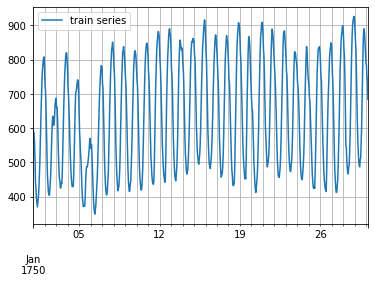

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

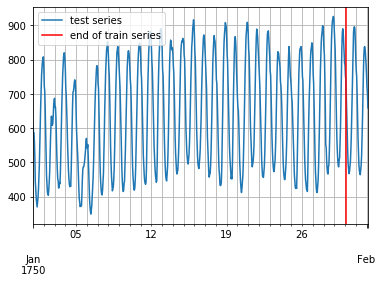

In [6]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [7]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GulonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [8]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

INFO:root:Using GPU


In [10]:
estimator = DeepAREstimator(
    prediction_length=dataset.metadata.prediction_length,
    use_feat_static_cat=True,
    cardinality=[
        feat_static_cat.cardinality
        for feat_static_cat in dataset.metadata.feat_static_cat
    ],
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                   )
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [11]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.26it/s, avg_epoch_loss=4.94]
INFO:root:Epoch[0] Elapsed time 12.111 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.937200
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.62it/s, avg_epoch_loss=4.14]
INFO:root:Epoch[1] Elapsed time 11.604 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.142991
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.42it/s, avg_epoch_loss=3.79]
INFO:root:Epoch[2] Elapsed time 11.880 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.794787
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.56it/s, avg_epoch_loss=3.63]
INFO:root:Epoch[3] Elapsed time 11.683 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.625184
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.49it/s, a

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [12]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [13]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [14]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [15]:
# first entry of the time series list
ts_entry = tss[0]

In [16]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [17]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [18]:
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

In [19]:
len(tss[0])

748

In [20]:
forecasts[0].samples.shape

(100, 48)

In [21]:
train_iteror = iter(dataset.test)
lens=[]
try:
    while True:
        entry=next(train_iteror)
        train_series = to_pandas(entry)
        lens.append(len(train_series))
except StopIteration:
    print('error')
    pass
    
set(lens)

error


{748, 1008}

The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [22]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [23]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


We can also do calculations to summarize the sample paths, such computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [24]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [650.19305 592.0112  551.37885 519.5827  497.3577  487.2263  491.67303
 505.96094 524.67334 565.95386 631.7137  699.1286  783.6099  841.1986
 890.54376 905.7097  906.59534 890.08716 868.1651  859.7972  809.7658
 783.69366 749.2395  702.0899  644.525   588.2194  549.973   516.23193
 494.4559  480.79156 485.44138 496.8806  520.0665  567.5943  634.5238
 705.7151  779.8567  838.66583 889.7756  909.03314 911.0397  889.3382
 873.41077 842.64966 822.76587 772.9236  738.93195 685.911  ]
0.5-quantile (median) of the future window:
 [651.61725 594.3874  551.62683 521.1138  499.67694 488.4168  493.75735
 505.70844 527.0544  566.3291  630.9868  701.9349  782.7469  839.4059
 893.69293 903.6383  901.8687  892.28894 869.9549  859.64325 814.2324
 781.1749  748.33673 703.2073  644.37744 589.005   550.9552  516.94946
 496.01892 482.7468  488.20892 496.11285 519.2147  566.14526 630.0864
 704.4571  780.9703  837.69635 885.9483  908.96735 911.2543  884.5481
 865.6215  839.03705 

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [25]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

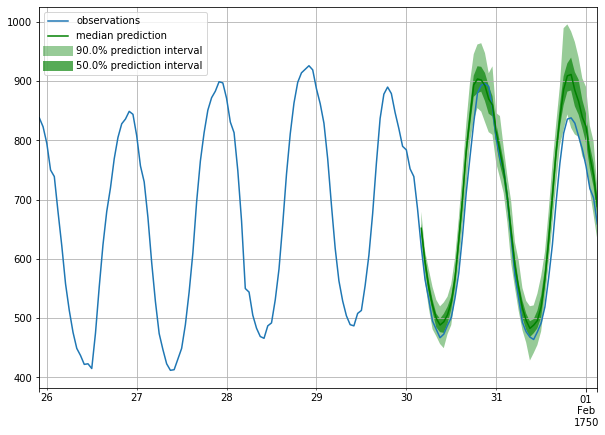

In [26]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [27]:
from gluonts.evaluation import Evaluator

In [28]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:03<00:00, 121.49it/s]


Aggregate metrics aggregate both across time-steps and across time series.

In [29]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 2401154.570469434,
    "abs_error": 6576306.3821697235,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 1.6249877586950872,
    "sMAPE": 0.1271801251249021,
    "MSIS": 16.8631435879862,
    "QuantileLoss[0.1]": 2831087.1587868696,
    "Coverage[0.1]": 0.0865539452495974,
    "QuantileLoss[0.5]": 6576306.45898962,
    "Coverage[0.5]": 0.4439915458937198,
    "QuantileLoss[0.9]": 3388723.353399467,
    "Coverage[0.9]": 0.8510970209339773,
    "RMSE": 1549.5659296943238,
    "NRMSE": 0.21154997636961653,
    "ND": 0.04517970406982053,
    "wQuantileLoss[0.1]": 0.01944977508600491,
    "wQuantileLoss[0.5]": 0.04517970459757882,
    "wQuantileLoss[0.9]": 0.023280776378694957,
    "mean_wQuantileLoss": 0.02930341868742623,
    "MAE_Coverage": 0.03945249597423516
}


Individual metrics are aggregated only across time-steps.

In [30]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,1977.995605,1758.252197,31644.0,659.250000,42.371302,0.864506,0.053729,10.850527,935.132446,0.416667,1758.252136,0.937500,678.010010,1.000000
1,NaN,147739.260417,17837.261719,124149.0,2586.437500,165.107988,2.250706,0.137766,43.944176,14844.260327,0.937500,17837.261597,1.000000,5442.962988,1.000000
2,NaN,28150.947917,6031.735352,65030.0,1354.791667,78.889053,1.592885,0.086611,39.710189,1841.188171,0.000000,6031.735413,0.083333,6606.765845,0.375000
3,NaN,107899.020833,12038.337891,235783.0,4912.145833,258.982249,0.968401,0.049671,6.349234,5375.280176,0.145833,12038.337891,0.583333,4641.111914,0.979167
4,NaN,34930.942708,7764.643555,131088.0,2731.000000,200.494083,0.806824,0.060950,4.932619,3087.815210,0.083333,7764.643433,0.312500,2515.149170,0.833333


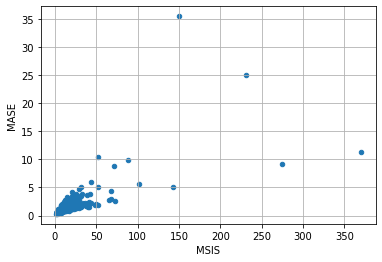

In [31]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()